In [1]:
include("../scripts/tools.jl")
include("../scripts/get_grid.jl")
include("../scripts/get_params.jl")
include("../scripts/plotting.jl")
include("../scripts/stable.jl")
include("../scripts/dynamics.jl")
include("../scripts/disturbances.jl")
include("../scripts/ps_analysis.jl");
using LinearAlgebra
using Statistics

In [2]:
border, scale_factor = import_border("../data/borders/border.json")

dx = 0.005
mesh = get_grid(border, dx); # renamed to be able to use the grid function for plotting

In [3]:
# compute or load grid parameters
contmod = get_params(mesh, scale_factor, "../data/disc/pantagruel.h5", Niter=60,
    dmax = 2*dx, patch=4000.0, bmin=0.0, tau=0.00001);

  4.338544 seconds (3.77 M allocations: 16.983 GiB, 4.70% gc time, 8.53% compilation time)
  8.632713 seconds (4.29 M allocations: 5.681 GiB, 4.76% gc time, 23.71% compilation time)


In [15]:
# save initial quantities
isgrid = copy(contmod.isgrid)
m0 = copy(contmod.m)
d0 = copy(contmod.d)
p0 = copy(contmod.p)
bx0 = copy(contmod.bx)
by0 = copy(contmod.by);

In [5]:
# create the list of edges
# the following is incomplete but should be sufficient
epsilon = Int64.(zeros(4*contmod.Nx*contmod.Ny, 2))
l = 1

for k in 1:contmod.Nx*contmod.Ny
    if(contmod.isinside[k])
        epsilon[l,:] = [k k+contmod.Ny]
        epsilon[l+1,:] = [k k+1]
        l +=2
    end
end

for id in 1:size(contmod.n,1)
    k = (Int64(contmod.n[id, 2]) - 1) * contmod.Ny + Int64(contmod.n[id, 1])
    ny = contmod.n[id, 3]
    nx = contmod.n[id, 4]
    if(nx == 0)
        epsilon[l,:] = [k k+contmod.Ny]
        #epsilon[l+1,:] = [k k-contmod.Ny]
        #l +=2
        l +=1
    elseif(nx == -1)
        epsilon[l,:] = [k k+contmod.Ny]
        l +=1
    elseif(nx == 1)
        #epsilon[l,:] = [k k-contmod.Ny]
        #l +=1
    end
    if(ny == 0)
        epsilon[l,:] = [k k+1]
        #epsilon[l+1,:] = [k k-1]
        l +=1
    elseif(ny == -1)
        epsilon[l,:] = [k k+1]
        l +=1
    elseif(ny == 1)
        #epsilon[l,:] = [k k-1]
        #l +=1
    end
end

epsilon = epsilon[1:l-1,:]

epsilon_new = Int64.(zeros(size(epsilon)))
id = findall(contmod.isgrid)
n = length(id)
#id = findall(contmod.isborder)
#println(id)
for i = 1:length(id)
    id1 = (epsilon[:,1] .== id[i])
    id2 = (epsilon[:,2] .== id[i])
    epsilon_new[id1,1] .= i
    epsilon_new[id2,2] .= i
end

grid_coord = contmod.coord[contmod.isgrid, :];

In [7]:
# DONT DO THIS PLOT IF dx is smaller than ~0.05
if(dx >= 0.05)
    plot(aspect_ratio=:equal, legend=false)
    for k = 1:size(epsilon_new,1)
        if(epsilon_new[k,1] != 0 && epsilon_new[k,2] != 0)
            #println(coord[[epsilon_new[k,1] epsilon_new[k,2]],2],)
            plot!(vec(grid_coord[[epsilon_new[k,1] epsilon_new[k,2]],2]),
                vec(grid_coord[[epsilon_new[k,1] epsilon_new[k,2]],1]),color=:black)
        end
    end
    scatter!(contmod.coord[contmod.isgrid,2], contmod.coord[contmod.isgrid,1])

    current()
end


In [10]:
N = size(epsilon_new,1)
id1 = [epsilon_new[:,1];epsilon_new[:,2]]
id2 = vec([1:N 1:N])
v = [-ones(N); ones(N)]
B = sparse(id1, id2, v)
L = B*B'

if(dx >= 0.01)
    Lfull = Array{Float64,2}(L)
    res = eigen(Lfull);
    temp = zeros(size(contmod.isgrid))
    temp[contmod.isgrid] = vec(res.vectors[:,3])
    hm_plot(contmod, temp; borders=[border])
end

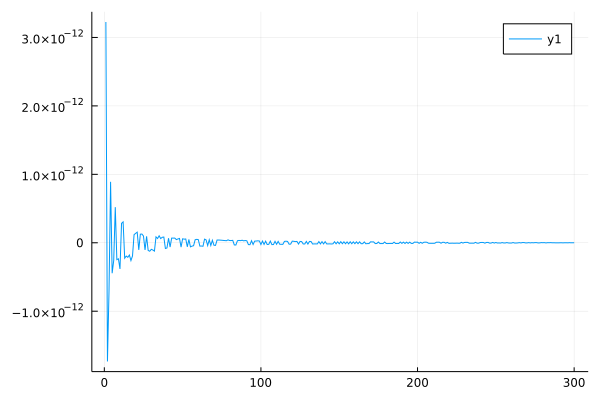

In [11]:
# perform Lanczos Algorithm

v = rand(n,1)
v = v .- mean(v)
v = v / norm(v)

w =  L * v
alpha = dot(w, v)
w = w - alpha * v

V = v
as = alpha
bs = []

Ncut = 300 # don't go to high or the eigenvectors you get do not satisfy sum(v)=0 any more

for i=2:Ncut
    beta = norm(w)
    if(beta > 1E-6)
        v = w / beta
    else
        println("CAWABUNGA")
        v = rand(n, 1)
        for j=1:i-1
            v -= dot(v, V[:,j]) * V[:,j]
        end
        v  /= norm(v)
    end

    w = L * v
    alpha = dot(w, v)
    w = w - alpha * v - beta * V[:,i-1]
    bs = [bs; beta]
    as = [as alpha]
    V = [V v]
end


T = zeros(Ncut, Ncut)
for i=1:Ncut
    T[i,i] = as[i]
end
for i=1:Ncut-1
    T[i, i+1] = bs[i]
    T[i+1, i] = bs[i]
end


res2 = eigen(T)
VV = V * res2.vectors;
s = zeros(Ncut)
for i=1:Ncut
    s[i] = sum(VV[:,i])
end
plot(s)

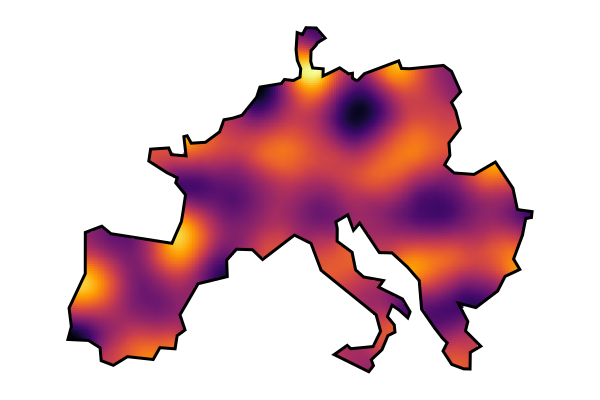

In [14]:
temp = zeros(size(contmod.isgrid))
temp[contmod.isgrid] = vec(VV[:,10])
hm_plot(contmod, temp; borders=[border])

In [50]:
# project the quantities over the modes

mred = ones(size(contmod.m))
dred = zeros(size(contmod.d))
pred = zeros(size(contmod.p))
bxred = zeros(size(contmod.bx))
byred = zeros(size(contmod.by))
mred[isgrid] .= mean(m0[isgrid])

dred[isgrid] .= mean(d0[isgrid])
pred .= mean(p0)
bxred[isgrid] .= mean(bx0[isgrid])
byred[isgrid] .= mean(by0[isgrid])

for i = 1:3
    mred[isgrid] += dot(m0[isgrid], vec(VV[:,i])) * vec(VV[:,i])
    dred[isgrid] += dot(d0[isgrid], vec(VV[:,i])) * vec(VV[:,i])
    bxred[isgrid] += dot(bx0[isgrid], vec(VV[:,i])) * vec(VV[:,i])
    byred[isgrid] += dot(by0[isgrid], vec(VV[:,i])) * vec(VV[:,i])
    pred += dot(p0, vec(VV[:,i])) * vec(VV[:,i])
end

-1.3969838619232178e-9
-399999.9999999958
4.423782229423523e-9


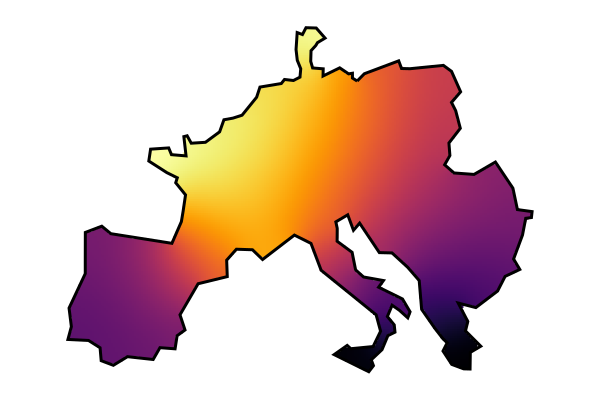

In [51]:
println(sum(pred))
println(sum(contmod.p))
println(sum(p0))
#hm_plot(contmod, contmod.m; borders=[border])
#temp = zeros(size(mred))
#temp[isgrid]
hm_plot(contmod, mred; borders=[border])

In [52]:
# compute or load grid parameters
contmod2 = get_params(mesh, scale_factor, "../data/disc/pantagruel.h5", Niter=60,
    dmax = 2*dx, patch=4000.0, bmin=0.0, tau=0.00001);
contmod2.m = mred
contmod2.d = dred
contmod2.p = pred
contmod2.bx = bxred
contmod2.by = byred

contmod2.bx = max.(contmod2.bx, mean(contmod2.bx[contmod.isgrid])) # the graph that I created is offset for bs
contmod2.by = max.(contmod2.by, mean(contmod2.by[contmod.isgrid])); #

  2.680560 seconds (529.82 k allocations: 16.811 GiB, 2.54% gc time)
  5.751015 seconds (18.57 k allocations: 5.442 GiB, 0.59% gc time)


In [22]:
# get stable solution
compute_stable_sol!(contmod2, interval = 10000, Niter = 250000, tol = 1e-7);

[10000.0 2.0008120696191067e-5]
[20000.0 8.4205804313231e-6]
[30000.0 4.355369325859115e-6]
[40000.0 2.477972106285087e-6]
[50000.0 1.4884237369283682e-6]
[60000.0 9.275862064006546e-7]
[70000.0 5.979107752240864e-7]
[80000.0 4.0073272733476273e-7]
[90000.0 2.8184980549461613e-7]
[100000.0 2.0990518234675903e-7]
[110000.0 1.6628994858880475e-7]
[120000.0 1.398266179508667e-7]
[130000.0 1.237634000839094e-7]
[140000.0 1.1401094657248478e-7]
[150000.0 1.0808926986793921e-7]
[160000.0 1.0449341059093342e-7]
[170000.0 1.0230979607950275e-7]
[180000.0 1.0098375136102788e-7]
[190000.0 1.0017847329457652e-7]
[200000.0 9.968944270077884e-8]
 23.409090 seconds (3.12 M allocations: 65.418 GiB, 4.50% gc time, 1.87% compilation time)


In [58]:
t_red, th_red, o_red = perform_dyn_sim(contmod2, interval=2,
    Ndt=2000, dt=0.01, method="cn");

Total time: 20.0
NIter: 2 Avg. Omega: -0.002208346529425097
NIter: 4 Avg. Omega: -0.00440645037016684
NIter: 6 Avg. Omega: -0.00659967110509344
NIter: 8 Avg. Omega: -0.008791394511568688
NIter: 10 Avg. Omega: -0.010982542086810355
NIter: 12 Avg. Omega: -0.01317148228835003
NIter: 14 Avg. Omega: -0.01535437951174313
NIter: 16 Avg. Omega: -0.01752597378318433
NIter: 18 Avg. Omega: -0.019680720511377134
NIter: 20 Avg. Omega: -0.021814101025126754
NIter: 22 Avg. Omega: -0.023923830355160675
NIter: 24 Avg. Omega: -0.02601067454617308
NIter: 26 Avg. Omega: -0.028078680736325756
NIter: 28 Avg. Omega: -0.030134795206124138
NIter: 30 Avg. Omega: -0.032187995341722994
NIter: 32 Avg. Omega: -0.0342481196892153
NIter: 34 Avg. Omega: -0.03632459246474852
NIter: 36 Avg. Omega: -0.03842525413366198
NIter: 38 Avg. Omega: -0.040555491575154715
NIter: 40 Avg. Omega: -0.04271777939391385
NIter: 42 Avg. Omega: -0.04491163826207522
NIter: 44 Avg. Omega: -0.047133944432450295
NIter: 46 Avg. Omega: -0.049379

NIter: 378 Avg. Omega: -0.06023024953303252
NIter: 380 Avg. Omega: -0.061232346420186955
NIter: 382 Avg. Omega: -0.06230946640632861
NIter: 384 Avg. Omega: -0.06346535061299763
NIter: 386 Avg. Omega: -0.06470142831833371
NIter: 388 Avg. Omega: -0.06601698397189833
NIter: 390 Avg. Omega: -0.0674098460944433
NIter: 392 Avg. Omega: -0.06887709808705678
NIter: 394 Avg. Omega: -0.07041569203309091
NIter: 396 Avg. Omega: -0.07202288747053268
NIter: 398 Avg. Omega: -0.07369619794899868
NIter: 400 Avg. Omega: -0.07543267880259137
NIter: 402 Avg. Omega: -0.07722796445799576
NIter: 404 Avg. Omega: -0.0790757480112605
NIter: 406 Avg. Omega: -0.08096796025248783
NIter: 408 Avg. Omega: -0.08289537408162698
NIter: 410 Avg. Omega: -0.08484846344863528
NIter: 412 Avg. Omega: -0.08681861967304827
NIter: 414 Avg. Omega: -0.08879950754020431
NIter: 416 Avg. Omega: -0.0907879079647595
NIter: 418 Avg. Omega: -0.09278367726575866
NIter: 420 Avg. Omega: -0.0947889543409248
NIter: 422 Avg. Omega: -0.096806736

NIter: 754 Avg. Omega: -0.15821960065192603
NIter: 756 Avg. Omega: -0.1578899826687253
NIter: 758 Avg. Omega: -0.1575886556745396
NIter: 760 Avg. Omega: -0.15731739960353025
NIter: 762 Avg. Omega: -0.1570754206089415
NIter: 764 Avg. Omega: -0.15686017800277885
NIter: 766 Avg. Omega: -0.15666843047619686
NIter: 768 Avg. Omega: -0.1564971392684573
NIter: 770 Avg. Omega: -0.15634408360133745
NIter: 772 Avg. Omega: -0.15620808870049543
NIter: 774 Avg. Omega: -0.1560887840659965
NIter: 776 Avg. Omega: -0.15598604389322906
NIter: 778 Avg. Omega: -0.15589938869647527
NIter: 780 Avg. Omega: -0.15582746497541802
NIter: 782 Avg. Omega: -0.15576762329337762
NIter: 784 Avg. Omega: -0.15571578274804038
NIter: 786 Avg. Omega: -0.155666815959619
NIter: 788 Avg. Omega: -0.1556153568243719
NIter: 790 Avg. Omega: -0.1555566366098841
NIter: 792 Avg. Omega: -0.15548698824717969
NIter: 794 Avg. Omega: -0.15540381559451094
NIter: 796 Avg. Omega: -0.15530503592586536
NIter: 798 Avg. Omega: -0.155188306837084

NIter: 1128 Avg. Omega: -0.16127607897599341
NIter: 1130 Avg. Omega: -0.16107901649209194
NIter: 1132 Avg. Omega: -0.16089890409926438
NIter: 1134 Avg. Omega: -0.16073429961733132
NIter: 1136 Avg. Omega: -0.16058342899492867
NIter: 1138 Avg. Omega: -0.16044424229675383
NIter: 1140 Avg. Omega: -0.1603144963252476
NIter: 1142 Avg. Omega: -0.16019189672201084
NIter: 1144 Avg. Omega: -0.16007428449846622
NIter: 1146 Avg. Omega: -0.15995977831192174
NIter: 1148 Avg. Omega: -0.1598467861212307
NIter: 1150 Avg. Omega: -0.1597339173574446
NIter: 1152 Avg. Omega: -0.15961992444316522
NIter: 1154 Avg. Omega: -0.15950370000065875
NIter: 1156 Avg. Omega: -0.15938424223561495
NIter: 1158 Avg. Omega: -0.15926060607597786
NIter: 1160 Avg. Omega: -0.15913196124528284
NIter: 1162 Avg. Omega: -0.15899778599479497
NIter: 1164 Avg. Omega: -0.1588580840140416
NIter: 1166 Avg. Omega: -0.15871347736867633
NIter: 1168 Avg. Omega: -0.15856515206651445
NIter: 1170 Avg. Omega: -0.1584147667670591
NIter: 1172 Avg

NIter: 1494 Avg. Omega: -0.16654943684997886
NIter: 1496 Avg. Omega: -0.16654120294336835
NIter: 1498 Avg. Omega: -0.1665410620201432
NIter: 1500 Avg. Omega: -0.16654873725623842
NIter: 1502 Avg. Omega: -0.16656392603360506
NIter: 1504 Avg. Omega: -0.16658616296684675
NIter: 1506 Avg. Omega: -0.1666146835698643
NIter: 1508 Avg. Omega: -0.16664833415491187
NIter: 1510 Avg. Omega: -0.16668561482883762
NIter: 1512 Avg. Omega: -0.1667248767800996
NIter: 1514 Avg. Omega: -0.16676455576436527
NIter: 1516 Avg. Omega: -0.16680333099089226
NIter: 1518 Avg. Omega: -0.16684022732482398
NIter: 1520 Avg. Omega: -0.1668746622118443
NIter: 1522 Avg. Omega: -0.16690634215579456
NIter: 1524 Avg. Omega: -0.16693500592119728
NIter: 1526 Avg. Omega: -0.16696017377813704
NIter: 1528 Avg. Omega: -0.16698102663724038
NIter: 1530 Avg. Omega: -0.166996386124775
NIter: 1532 Avg. Omega: -0.1670047368105985
NIter: 1534 Avg. Omega: -0.16700434411893142
NIter: 1536 Avg. Omega: -0.16699353843180567
NIter: 1538 Avg. 

NIter: 1862 Avg. Omega: -0.17249436724968778
NIter: 1864 Avg. Omega: -0.17256737463449712
NIter: 1866 Avg. Omega: -0.17263781525014646
NIter: 1868 Avg. Omega: -0.1727044675212637
NIter: 1870 Avg. Omega: -0.17276590145210313
NIter: 1872 Avg. Omega: -0.1728205767551207
NIter: 1874 Avg. Omega: -0.17286699624587795
NIter: 1876 Avg. Omega: -0.1729038797879608
NIter: 1878 Avg. Omega: -0.17293031677839316
NIter: 1880 Avg. Omega: -0.17294587085742436
NIter: 1882 Avg. Omega: -0.17295064525949566
NIter: 1884 Avg. Omega: -0.17294531228644458
NIter: 1886 Avg. Omega: -0.17293106303402167
NIter: 1888 Avg. Omega: -0.17290944573171557
NIter: 1890 Avg. Omega: -0.1728821310205912
NIter: 1892 Avg. Omega: -0.17285067790092765
NIter: 1894 Avg. Omega: -0.17281635640415877
NIter: 1896 Avg. Omega: -0.17278005515599618
NIter: 1898 Avg. Omega: -0.17274228799267816
NIter: 1900 Avg. Omega: -0.1727032862781315
NIter: 1902 Avg. Omega: -0.17266311509433174
NIter: 1904 Avg. Omega: -0.17262174050817888
NIter: 1906 Avg

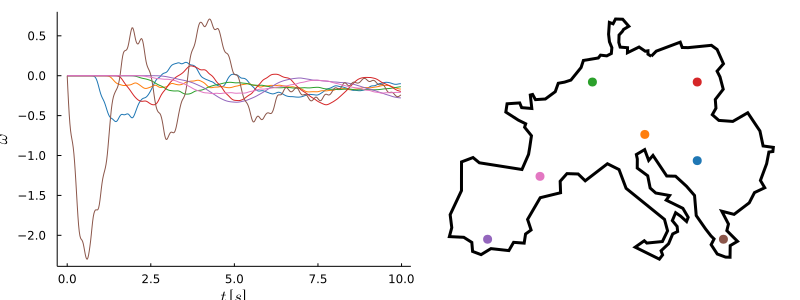

In [59]:
# check what's going on
c = [500 -250; 0.0 0.0; -500 500; 500. 500.; -1500.0 -1000.0; 750.0 -1000; -1000 -400] / scale_factor
#c = [-1500.0 -1000.0] / scale_factor
time_plot(contmod2, t_red, o_red, c, borders = [border], tstart = 0.0, tend = 10.0)

In [56]:
# reset the initial angles to their last simulation values
contmod2.th[contmod2.isgrid] = th_red[:,end];

In [57]:
# when stabilize add the disturbance
add_local_disturbance!(contmod2, [-0.35; 0.24], -10.0, 0.02, dx);

In [32]:
# now with the full model for comparison
# get stable solution
compute_stable_sol!(contmod, interval = 10000, Niter = 250000, tol = 1e-7);

[10000.0 8.967028682205225e-5]
[20000.0 1.6800536459804505e-5]
[30000.0 7.560662368344406e-6]
[40000.0 4.468104524368854e-6]
[50000.0 2.668583756304521e-6]
[60000.0 1.6090216313768835e-6]
[70000.0 9.826460688477923e-7]
[80000.0 6.118867436066822e-7]
[90000.0 3.9235161575224e-7]
[100000.0 2.623499975040744e-7]
[110000.0 1.8536727264262254e-7]
[120000.0 1.3978127744174174e-7]
[130000.0 1.1278747580334425e-7]
[140000.0 9.680320034455292e-8]
 16.332852 seconds (1.26 M allocations: 45.741 GiB, 2.41% gc time)


In [35]:
t_full, th_full, o_full = perform_dyn_sim(contmod, interval=2,
    Ndt=2000, dt=0.01, method="cn");

Total time: 20.0
NIter: 2 Avg. Omega: -0.00220971199143039
NIter: 4 Avg. Omega: -0.004409031284061278
NIter: 6 Avg. Omega: -0.006603249707761337
NIter: 8 Avg. Omega: -0.008795753571499684
NIter: 10 Avg. Omega: -0.010987502053723178
NIter: 12 Avg. Omega: -0.013176911785862461
NIter: 14 Avg. Omega: -0.015360195767478421
NIter: 16 Avg. Omega: -0.01753213865971252
NIter: 18 Avg. Omega: -0.01968723637219523
NIter: 20 Avg. Omega: -0.021821004706221836
NIter: 22 Avg. Omega: -0.02393118559521874
NIter: 24 Avg. Omega: -0.026018564486961146
NIter: 26 Avg. Omega: -0.028087200380622165
NIter: 28 Avg. Omega: -0.03014404395175436
NIter: 30 Avg. Omega: -0.0321980679780662
NIter: 32 Avg. Omega: -0.03425909962508752
NIter: 34 Avg. Omega: -0.036336545951068215
NIter: 36 Avg. Omega: -0.03843822719486662
NIter: 38 Avg. Omega: -0.04056950696174021
NIter: 40 Avg. Omega: -0.04273283183238703
NIter: 42 Avg. Omega: -0.04492768960462405
NIter: 44 Avg. Omega: -0.0471509199646111
NIter: 46 Avg. Omega: -0.04939727

NIter: 378 Avg. Omega: -0.06022113907058429
NIter: 380 Avg. Omega: -0.06122404856942771
NIter: 382 Avg. Omega: -0.062301967731401287
NIter: 384 Avg. Omega: -0.06345862052950883
NIter: 386 Avg. Omega: -0.06469542511183535
NIter: 388 Avg. Omega: -0.06601166464229705
NIter: 390 Avg. Omega: -0.06740517560447885
NIter: 392 Avg. Omega: -0.06887305774767448
NIter: 394 Avg. Omega: -0.0704122827952209
NIter: 396 Avg. Omega: -0.0720201304731232
NIter: 398 Avg. Omega: -0.07369413186471273
NIter: 400 Avg. Omega: -0.07543135439099599
NIter: 402 Avg. Omega: -0.07722743678953858
NIter: 404 Avg. Omega: -0.07907606843041062
NIter: 406 Avg. Omega: -0.08096916924266169
NIter: 408 Avg. Omega: -0.08289749584658837
NIter: 410 Avg. Omega: -0.08485150515169847
NIter: 412 Avg. Omega: -0.08682257506874967
NIter: 414 Avg. Omega: -0.0888043595538216
NIter: 416 Avg. Omega: -0.09079362992463154
NIter: 418 Avg. Omega: -0.09279023322969795
NIter: 420 Avg. Omega: -0.09479629974417549
NIter: 422 Avg. Omega: -0.09681482

NIter: 754 Avg. Omega: -0.15819440758890632
NIter: 756 Avg. Omega: -0.1578648169682236
NIter: 758 Avg. Omega: -0.15756351399388918
NIter: 760 Avg. Omega: -0.15729227731531972
NIter: 762 Avg. Omega: -0.1570503133930648
NIter: 764 Avg. Omega: -0.15683508254675402
NIter: 766 Avg. Omega: -0.1566433455874739
NIter: 768 Avg. Omega: -0.15647206873367903
NIter: 770 Avg. Omega: -0.15631903679026324
NIter: 772 Avg. Omega: -0.15618308180168014
NIter: 774 Avg. Omega: -0.15606384001250745
NIter: 776 Avg. Omega: -0.15596119278098597
NIter: 778 Avg. Omega: -0.1558746659435576
NIter: 780 Avg. Omega: -0.15580291022595222
NIter: 782 Avg. Omega: -0.1557432774314424
NIter: 784 Avg. Omega: -0.15569168537470982
NIter: 786 Avg. Omega: -0.15564300126703476
NIter: 788 Avg. Omega: -0.15559184939700824
NIter: 790 Avg. Omega: -0.1555334502382356
NIter: 792 Avg. Omega: -0.15546412603903478
NIter: 794 Avg. Omega: -0.15538127360392454
NIter: 796 Avg. Omega: -0.1552828066417402
NIter: 798 Avg. Omega: -0.1551663830459

NIter: 1128 Avg. Omega: -0.16127643256856436
NIter: 1130 Avg. Omega: -0.16107899863758787
NIter: 1132 Avg. Omega: -0.16089851103397593
NIter: 1134 Avg. Omega: -0.16073352933871943
NIter: 1136 Avg. Omega: -0.16058228064554833
NIter: 1138 Avg. Omega: -0.16044271792905443
NIter: 1140 Avg. Omega: -0.1603126016979054
NIter: 1142 Avg. Omega: -0.16018964227302793
NIter: 1144 Avg. Omega: -0.16007168442147413
NIter: 1146 Avg. Omega: -0.15995684733536164
NIter: 1148 Avg. Omega: -0.15984353915322233
NIter: 1150 Avg. Omega: -0.15973036766336166
NIter: 1152 Avg. Omega: -0.15961608500145624
NIter: 1154 Avg. Omega: -0.1594995832698385
NIter: 1156 Avg. Omega: -0.15937985933105261
NIter: 1158 Avg. Omega: -0.15925596667730504
NIter: 1160 Avg. Omega: -0.1591270731272104
NIter: 1162 Avg. Omega: -0.15899265492600137
NIter: 1164 Avg. Omega: -0.15885271231804776
NIter: 1166 Avg. Omega: -0.1587078638549513
NIter: 1168 Avg. Omega: -0.15855929128867466
NIter: 1170 Avg. Omega: -0.1584086508803342
NIter: 1172 Avg

NIter: 1496 Avg. Omega: -0.16654785416509743
NIter: 1498 Avg. Omega: -0.16654769098783642
NIter: 1500 Avg. Omega: -0.16655533540575257
NIter: 1502 Avg. Omega: -0.16657048397174076
NIter: 1504 Avg. Omega: -0.16659267090088412
NIter: 1506 Avg. Omega: -0.16662113165942888
NIter: 1508 Avg. Omega: -0.16665471306962495
NIter: 1510 Avg. Omega: -0.16669191681643097
NIter: 1512 Avg. Omega: -0.1667310959521801
NIter: 1514 Avg. Omega: -0.16677068819000518
NIter: 1516 Avg. Omega: -0.16680937469231868
NIter: 1518 Avg. Omega: -0.16684618121486136
NIter: 1520 Avg. Omega: -0.16688052595071026
NIter: 1522 Avg. Omega: -0.16691211542095608
NIter: 1524 Avg. Omega: -0.16694068839730947
NIter: 1526 Avg. Omega: -0.16696576465433624
NIter: 1528 Avg. Omega: -0.16698652513918627
NIter: 1530 Avg. Omega: -0.16700179089587497
NIter: 1532 Avg. Omega: -0.16701004631568628
NIter: 1534 Avg. Omega: -0.16700955584055188
NIter: 1536 Avg. Omega: -0.16699864874996798
NIter: 1538 Avg. Omega: -0.16697607771501272
NIter: 1540

NIter: 1864 Avg. Omega: -0.17256774651254358
NIter: 1866 Avg. Omega: -0.17263823836467423
NIter: 1868 Avg. Omega: -0.1727049420766553
NIter: 1870 Avg. Omega: -0.1727664271791407
NIter: 1872 Avg. Omega: -0.17282115307967685
NIter: 1874 Avg. Omega: -0.17286762214941453
NIter: 1876 Avg. Omega: -0.17290455362241933
NIter: 1878 Avg. Omega: -0.1729310358181347
NIter: 1880 Avg. Omega: -0.1729466319881265
NIter: 1882 Avg. Omega: -0.17295144484130534
NIter: 1884 Avg. Omega: -0.1729461467633098
NIter: 1886 Avg. Omega: -0.17293192926740047
NIter: 1888 Avg. Omega: -0.1729103414249157
NIter: 1890 Avg. Omega: -0.17288305528149886
NIter: 1892 Avg. Omega: -0.172851631245282
NIter: 1894 Avg. Omega: -0.17281734071533
NIter: 1896 Avg. Omega: -0.172781072673813
NIter: 1898 Avg. Omega: -0.17274334115969936
NIter: 1900 Avg. Omega: -0.1727043774354857
NIter: 1902 Avg. Omega: -0.17266424598438826
NIter: 1904 Avg. Omega: -0.17262291241747796
NIter: 1906 Avg. Omega: -0.17258024626664784
NIter: 1908 Avg. Omega: 

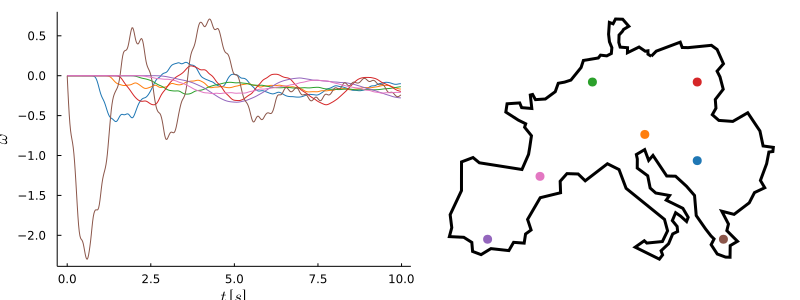

In [37]:
c = [500 -250; 0.0 0.0; -500 500; 500. 500.; -1500.0 -1000.0; 750.0 -1000; -1000 -400] / scale_factor
#c = [-1500.0 -1000;] / scale_factor
time_plot(contmod, t_full, o_full, c, borders = [border], tstart = 0.0, tend = 10.0)

In [ ]:
# reset the initial angles to their last simulation values
contmod.th[contmod.isgrid] = thetas[:,end];

In [34]:
add_local_disturbance!(contmod, [-0.35; 0.24], -10.0, 0.02, dx);
println(sum(contmod.p)*dx^2)

-9.999999999999895


In [38]:
id = Int64.(zeros(size(c,1)))
grid_coord = contmod.coord[contmod.isgrid,:]
    
for i in 1:length(id)
    id[i] = argmin((grid_coord[:,1] .- c[i,2]).^2 + (grid_coord[:,2] .- c[i,1]).^2)
end

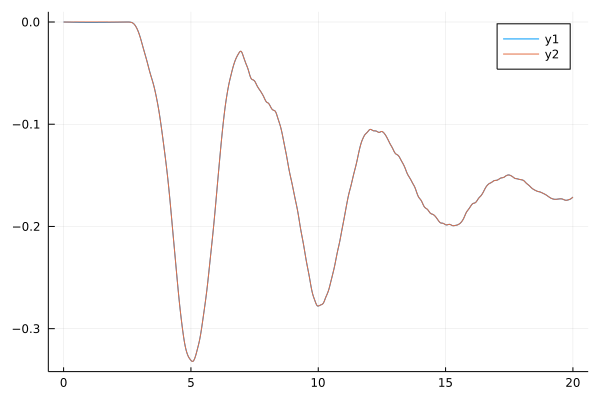

In [67]:
plot(t_full, o_full[id[5],:])
plot!(t_red, o_red[id[5],:])

In [ ]:
sum(abs.(contmod.m-contmod2.m))

In [ ]:
sum(abs.(o_red[id,:]-o_full[id,:]))

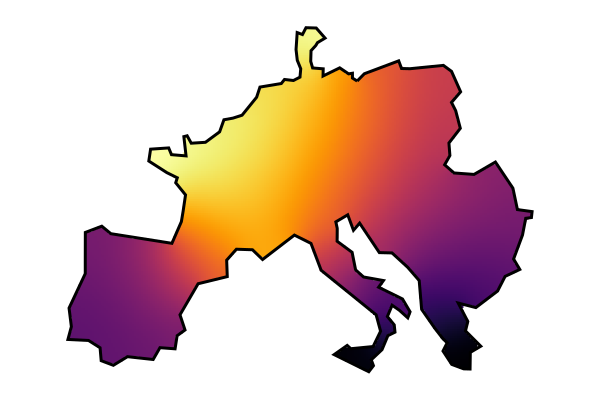

In [62]:
hm_plot(contmod2, contmod2.m; borders=[border])